In [ ]:
!nvidia-smi

Thu May 27 14:18:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Libraries**

In [ ]:
import string
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import sys,time,os,warnings
warnings.filterwarnings('ignore')
import re
import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, LSTM, Embedding, Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

**Acessing data**

In [ ]:
img_path = '/content/drive/MyDrive/Flickr8k/Images'
txt_path = '/content/drive/MyDrive/Flickr8k/captions.txt'
allimg   = os.listdir(img_path)
img      = []
# for im in allimg:
#   if im[-4:]!='.npy':
#     img.append(im)

print(f'Total Images = {len(img)}')

Total Images = 8091


**Reading Captions and the corresponding image name written in captions.txt file**

In [ ]:
file = open(txt_path , 'r')
text = file.read()
file.close()
textli = []
for line in text.split('\n'):
  col = line.split(',')
  if len(col) == 1:
    continue
  img = col[0]
  cap = ",".join(col[1:])
  textli.append([img,cap])

data = pd.DataFrame(textli[1:] , columns = ['image', 'caption'])
uni_filenames = np.unique(data.image.values)

In [ ]:
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


**Plotting image and corresponding caption**

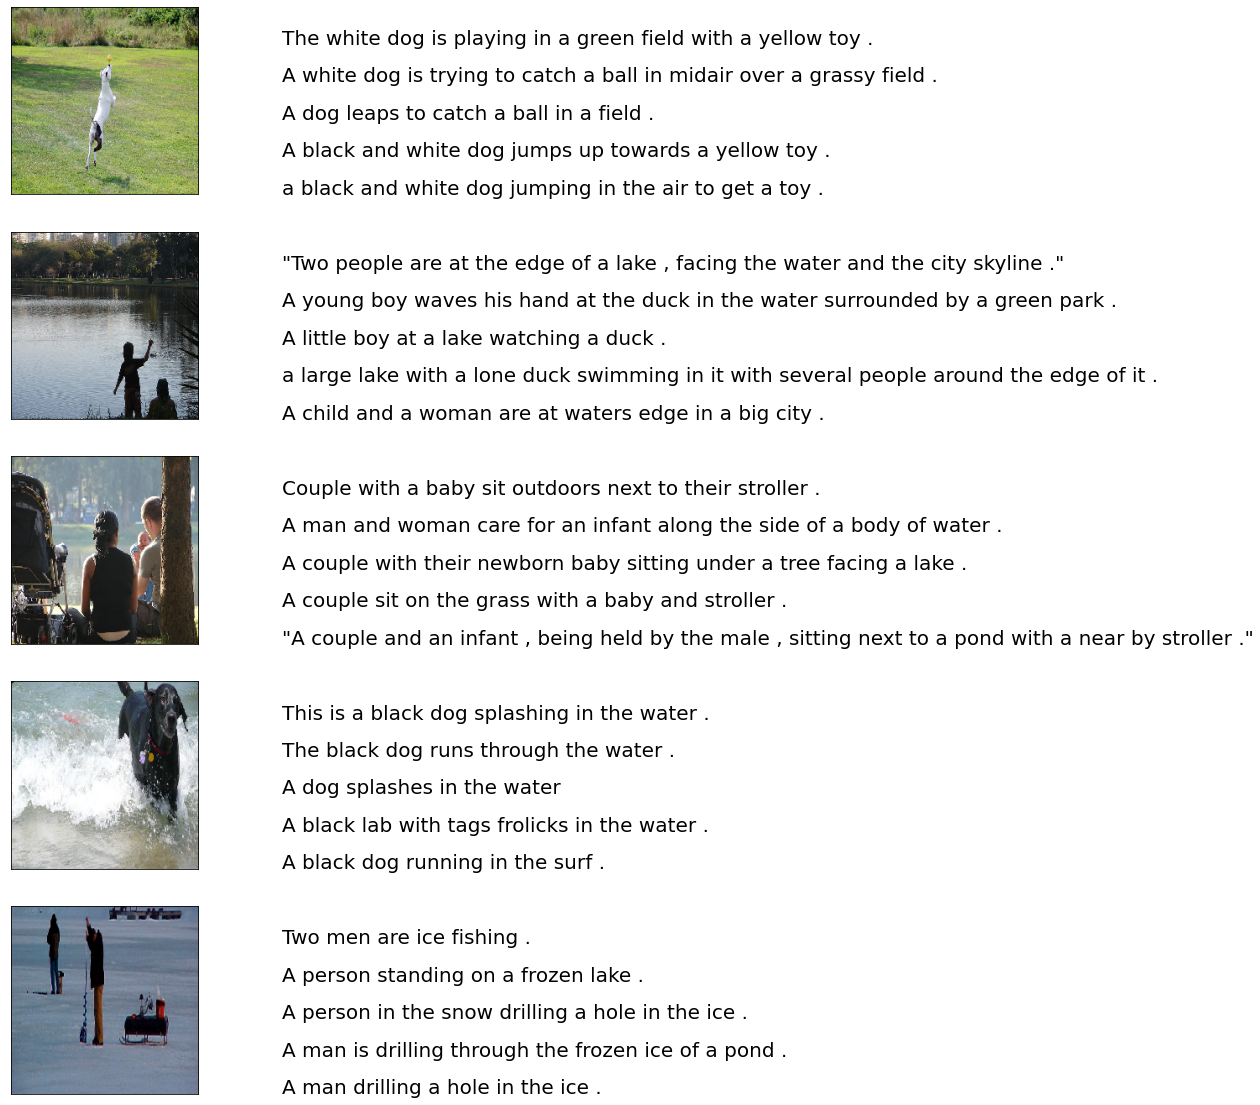

In [ ]:
npic = 5 
npix = 224
targetsize =  (npix , npix , 3)
count = 1

fig = plt.figure(figsize = (10,20))
for im in uni_filenames[15:20]:
  filename = img_path + '/' + im
  captions = list(data['caption'].loc[data['image']==im].values)
  image_load = load_img(filename, target_size = targetsize)
  ax = fig.add_subplot(npic , 2, count, xticks=[], yticks=[])
  ax.imshow(image_load)
  count+=1
  ax = fig.add_subplot(npic,2,count)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(captions))
  for i, caption in enumerate(captions):
    ax.text(0,i,caption,fontsize=20)
  count+=1
plt.show()

**Without Lemmatization there are 9862 different alphabets/characters/numbers in the caption**

In [ ]:
vocabulary = []
for txt in data.caption.values:
  vocabulary.extend(txt.split())
print(f'Vocabulary Size {len(set(vocabulary))}')

Vocabulary Size 9862


**Lemmatization by Removing punctuation, single character, numeric values**

In [ ]:
def remove_punctuation(text_original):
  text_no_punctuation = text_original.translate(string.punctuation)
  return (text_no_punctuation)

def remove_single_character(text):
  text_len_more_than1 = []
  for word in text.split():
    if len(word) > 1:
      text_len_more_than1.append(word)
  return " ".join(text_len_more_than1)

def remove_numeric(text):
  text_no_numeric = ""
  for word in text.split():
    isalpha = word.isalpha()
    if isalpha:
      text_no_numeric += " " + word
  return text_no_numeric

def text_clean(text_original):
  text = remove_punctuation(text_original)
  text = remove_single_character(text)
  text = remove_numeric(text)
  return text

for i , caption in enumerate(data.caption.values):
  newcaption = text_clean(caption)
  data['caption'].iloc[i] = newcaption


**Vocab size decreased to 9008 from 9862 but still we will not use the all the words, we will take on 5000 words into our vocabulary. You can take all words if you want. **

In [ ]:
clean_vocab = []
for txt in data.caption.values:
  clean_vocab.extend(txt.split())
print(f"Clean Vocab Size = {len(set(clean_vocab))}")

Clean Vocab Size = 9008


**Adding <start> and <end> in caption to so that rnn could understand when to stop**

In [ ]:
all_captions = []
for captions in data['caption'].astype(str):
  caption = '<start>' + captions + ' <end>'
  all_captions.append(caption)
all_captions[:20]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> Two dogs of different breeds looking at each other on the road <end>',
 '<start> Two dogs on pavement moving toward each other <end>',
 '<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
 '<start> little girl is sitting in front of large painted rainbow <end>',
 '<start> small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it <end>',
 '<start> 

**Creating a list img_name_vector which has path to the image from the drive.These list has duplicates of img_name since names these are taken directly form captions.txt and single image has multiple captions. **

In [ ]:
PATH = '/content/drive/MyDrive/Flickr8k/Images/'
all_img_name_vector = []
for annot in data['image']:
  full_img_path = PATH + annot
  all_img_name_vector.append(full_img_path)

all_img_name_vector[:10]

['/content/drive/MyDrive/Flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Flickr8k/Images/1001773457_577c3a7d70.jpg']

In [ ]:
print(f'len(all image name vector) : {len(all_img_name_vector)}')
print(f'len(all captions) : {len(all_captions)}')

len(all image name vector) : 40455
len(all captions) : 40455


**We will take only 40000 images and corresponding caption since it forms 625 batches correctly. We are shuffling so that we can minimize duplicates**

In [ ]:
def data_limiter(num , total_captions , all_img_name_vector):
  train_captions , img_name_vector = shuffle(total_captions , all_img_name_vector , random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions , img_name_vector

train_captions,img_name_vector = data_limiter(40000, all_captions, all_img_name_vector)

**As name suggest load_image loads the image and resize it to (224,224) so the image size is (224,224,3)**

In [ ]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (224,224))
  img = preprocess_input(img)
  return img, image_path


**Feature_mod is vgg16 with only convolution layers. We will use feature_mod for encoding image**

In [ ]:
image_model = tf.keras.applications.VGG16(include_top = False , weights = 'imagenet')
new_input   = image_model.input
hidden      = image_model.layers[-1].output
feature_mod = Model(new_input , hidden)
feature_mod.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


**img_dataset loads images batchwise parallely so that we can create npy of files without consuming more ram**

In [ ]:
encode_train = sorted(set(img_name_vector))
img_dataset  = tf.data.Dataset.from_tensor_slices(encode_train)
img_dataset  = img_dataset.map(load_image , num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(64)

**saving the encoded images in npy form so that we can load it faster from next time onwards.**

In [ ]:
%%time
for img, path in tqdm(img_dataset):
  batch_features = feature_mod(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0] , -1 , batch_features.shape[3]))

  for bf , p in zip(batch_features , path):
    path_of_feature = p.numpy().decode('utf-8')
    np.save(path_of_feature , bf.numpy())

100%|██████████| 127/127 [36:21<00:00, 17.18s/it]

CPU times: user 2min 47s, sys: 8.35 s, total: 2min 56s
Wall time: 36min 21s


**Taking top 5000 occuring words in vocab and tokenizing rest words as <unk>. We are padding the caption to the max caption length in the dataset. "Post" means padding after the caption**

In [ ]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k,
                                                  oov_token='<unk>',
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs , padding = 'post')

In [ ]:
print(train_captions[:3])
print(train_seqs[:3])

['<start> Several children leaping into pile of leaves on the ground <end>', '<start> man hiking in the wilderness giving the camera thumbs up <end>', '<start> white dog is running through the water onto the shore <end>']
[[2, 187, 62, 330, 64, 522, 12, 328, 6, 5, 167, 3], [2, 11, 588, 4, 5, 2380, 893, 5, 94, 1278, 53, 3], [2, 14, 9, 7, 32, 33, 5, 24, 238, 5, 279, 3]]


In [ ]:
def calc_max_length(tensor):
  return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
  return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print(f'Max length of any caption : {max_length}')
print(f'Min length of any caption : {min_length}')

Max length of any caption : 32
Min length of any caption : 2


**spliting data into 80:20 split**

In [ ]:
img_train , img_val , cap_train , cap_val = train_test_split(img_name_vector, cap_vector , test_size = 0.2 , random_state=42)

In [ ]:
batch_size = 64
buffersize = 1000
embedd_dim = 256
units      = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps  = len(img_train)// batch_size
feat_shape = 512
attention  = 49

**mapping image with caption and loading batchwise **

In [ ]:
def map_func(img_name ,cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor , cap

dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))

dataset = dataset.map(lambda item1 , item2: tf.numpy_function(
    map_func, [item1 , item2], [tf.float32 , tf.int32]),
    num_parallel_calls = tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(buffersize).batch(batch_size)
dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

**Creating Encoder and Decoder Architecture. Previously we used feature_mod for encoding image and store it in its reduced form. Since it is less time consuming to load smaller file. Now we will take encoded image and pass it to our actual encoder so that it can convert it to single vector using fully connected layer**

In [ ]:
class VGG16_Encoder(tf.keras.Model):
  def __init__(self, embedding_dim):
    super(VGG16_Encoder , self).__init__()
    self.fc = tf.keras.layers.Dense(embedding_dim)
    self.dropout = tf.keras.layers.Dropout(0.5 , noise_shape = None , seed = None)
  
  def call(self, x):
    x = self.fc(x)
    x = tf.nn.relu(x)
    return x

**Decoder architecture**

In [ ]:
def rnn_type(units):
  if tf.test.is_gpu_available():
    return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                               return_sequences= True,
                                               return_state = True,
                                               recurrent_intializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units,
                               return_sequences = True,
                               return_state = True,
                               recurrent_activation = 'sigmoid',
                               recurrent_intializer = 'glorot_uniform')

In [ ]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim , units , vocab_size):
    super(Rnn_Local_Decoder , self).__init__()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(vocab_size , embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences = True,
                                  return_state = True,
                                  recurrent_initializer = 'glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)

    self.dropout = tf.keras.layers.Dropout(0.5 , noise_shape=None , seed=None)
    self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1 , momentum=0.99,epsilon = 0.001,
                                                                center=True , scale = True, beta_initializer='zeros',gamma_initializer = 'ones',
                                                                moving_mean_initializer='zeros', moving_variance_initializer='ones',beta_regularizer=None,
                                                                gamma_regularizer=None,beta_constraint=None,gamma_constraint=None)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.Uattn = tf.keras.layers.Dense(units)
    self.Wattn = tf.keras.layers.Dense(units)
    self.Vattn = tf.keras.layers.Dense(1)

  def call(self, x, features, hidden):
    # features shape ==> (64,49,256) ==> Output from ENCODER
    # hidden shape == (batch_size, hidden_size) ==>(64,512)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)
    hidden_with_time_axis = tf.expand_dims(hidden , 1)
    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score , axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector , axis =1)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector , 1) , x], axis=-1)
    output,state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x,(-1,x.shape[2]))
    x = self.dropout(x)
    x = self.batchnormalization(x)
    x = self.fc2(x)
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size , self.units))

encoder = VGG16_Encoder(embedd_dim)
decoder = Rnn_Local_Decoder(embedd_dim , units, vocab_size)

**Specifying Optimizer and loss function**

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction='none'
)
def loss_function(real , pred):
  mask = tf.math.logical_not(tf.math.equal(real , 0))
  loss_ = loss_object(real , pred)
  mask = tf.cast(mask , dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

**Creating Train Function**

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor , target):
  loss=0
  hidden = decoder.reset_state(batch_size = target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']]*batch_size , 1)

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
      predictions , hidden, _ = decoder(dec_input , features ,hidden)
      loss+= loss_function(target[:,i] , predictions)
      dec_input = tf.expand_dims(target[:,i],1)
  total_loss = (loss/int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients , trainable_variables))

  return loss, total_loss


**Since we have created our own train function. we may not able to use callbacks. We will use checkpoint for saving the model with minimal loss **

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Flickr8k"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

**Training**

In [ ]:
epochs = 20
for epoch in range(start_epoch , epochs):
  start = time.time()
  total_loss = 0
  upck = np.inf
  for (batch , (img_tensor, target)) in enumerate(dataset):
    batch_loss, t_loss = train_step(img_tensor , target)
    total_loss+=t_loss

    if batch%100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1, batch , batch_loss.numpy() / int(target.shape[1])))
  if total_loss/num_steps <= upck:
    ckpt_manager.save()
    upck = total_loss/num_steps
  
  loss_plot.append(total_loss / num_steps)
  print('Epoch {} Loss {:.6f}'.format(epoch+1, total_loss/num_steps))
  print('Time take for 1 epoch {} sec\n'.format(time.time()-start))

Epoch 1 Batch 0 Loss 2.7981
Epoch 1 Batch 100 Loss 1.7560
Epoch 1 Batch 200 Loss 1.5213
Epoch 1 Batch 300 Loss 1.4430
Epoch 1 Batch 400 Loss 1.2214
Epoch 1 Loss 1.498194
Time take for 1 epoch 206.0002715587616 sec

Epoch 2 Batch 0 Loss 1.1987
Epoch 2 Batch 100 Loss 1.0587
Epoch 2 Batch 200 Loss 1.1514
Epoch 2 Batch 300 Loss 1.1493
Epoch 2 Batch 400 Loss 1.0545
Epoch 2 Loss 1.150325
Time take for 1 epoch 161.0924768447876 sec

Epoch 3 Batch 0 Loss 1.1048
Epoch 3 Batch 100 Loss 1.1261
Epoch 3 Batch 200 Loss 1.0011
Epoch 3 Batch 300 Loss 0.9718
Epoch 3 Batch 400 Loss 1.0161
Epoch 3 Loss 1.031525
Time take for 1 epoch 160.53290247917175 sec

Epoch 4 Batch 0 Loss 1.0451
Epoch 4 Batch 100 Loss 1.0645
Epoch 4 Batch 200 Loss 0.9527
Epoch 4 Batch 300 Loss 0.8864
Epoch 4 Batch 400 Loss 0.8490
Epoch 4 Loss 0.946641
Time take for 1 epoch 160.9910056591034 sec

Epoch 5 Batch 0 Loss 0.9433
Epoch 5 Batch 100 Loss 0.9365
Epoch 5 Batch 200 Loss 0.9516
Epoch 5 Batch 300 Loss 0.8756
Epoch 5 Batch 400 Los

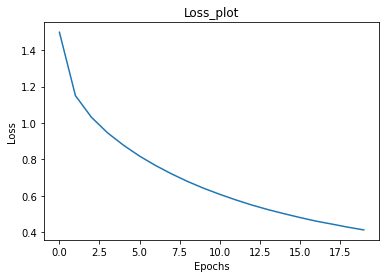

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plot')
plt.show()

In [ ]:
def evaluate(image):
  attention_plot = np.zeros((max_length , attention))
  hidden = decoder.reset_state(batch_size =1)
  temp_input = tf.expand_dims(load_image(image)[0],0)
  img_tensor_val = feature_mod(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val , (img_tensor_val.shape[0] , -1 , img_tensor_val.shape[3]))
  features = encoder(img_tensor_val)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']],0)
  result = []
  for i in range(max_length):
    predictions, hidden, attention_weights = decoder(dec_input , features , hidden)
    attention_plot[i] = tf.reshape(attention_weights , (-1, )).numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    result.append(tokenizer.index_word[predicted_id])
    if tokenizer.index_word[predicted_id] == '<end>':
      return result, attention_plot

    dec_input = tf.expand_dims([predicted_id],0)
  attention_plot = attention_plot[:len(result) , :]

  return result , attention_plot

In [ ]:
def plot_attention(image , result , attention_plot):
  temp_image = np.array(Image.open(image))
  fig = plt.figure(figsize = (10,10))
  len_result = len(result)
  for l in range(len_result):
    temp_att = np.resize(attention_plot[l] , (8,8))
    ax =fig.add_subplot(len_result//2 , len_result//2 , l+1)
    ax.set_title(result[l])
    img = ax.imshow(temp_image)
    ax.imshow(temp_att, cmap='gray',alpha = 0.6 , extent=img.get_extent())
  
  plt.tight_layout()
  plt.show()

Bleu Score: 44.17918226831577
Real Caption: small dog swims in pool
Prediction Caption:  black dog swims in the pool


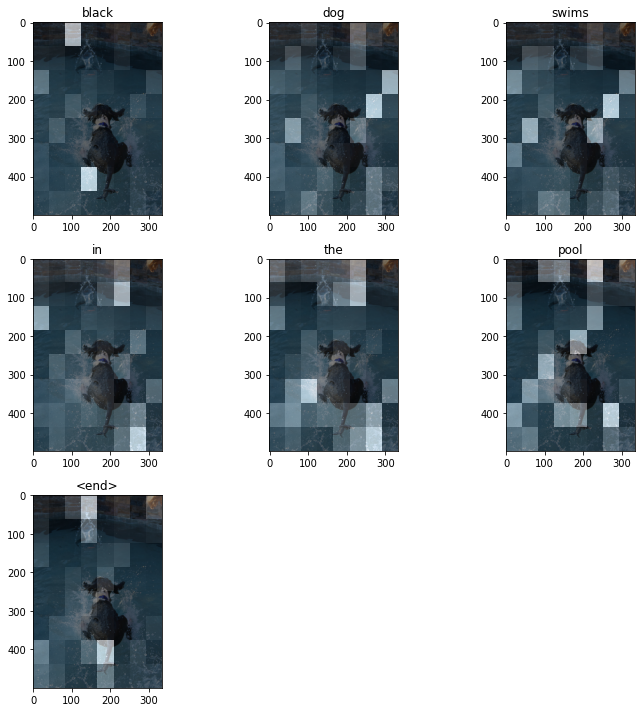

In [ ]:
rid = np.random.randint(0, len(img_train))
image = img_train[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_train[rid] if i not in [0,1,2,3]])
result , attention_plot = evaluate(image)
first = real_caption.split(' ', 1)[1]

for i in result:
  if i=='<unk>':
    result.remove(i)

for i in real_caption:
  if i=='<unk>':
    real_caption.remove(i)

result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result
score = sentence_bleu(reference , candidate)
print(f'Bleu Score: {score*100}')
print('Real Caption:', real_caption)
print('Prediction Caption: ',result_final)
plot_attention(image , result , attention_plot)

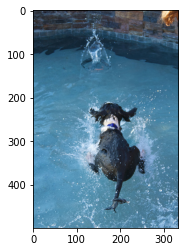

In [ ]:
img = Image.open(image)
plt.imshow(img)

**References :**

1. https://www.analyticsvidhya.com/blog/2020/11/attention-mechanism-for-caption-generation/
2. https://www.tensorflow.org/tutorials/text/image_captioning  



***ThankYou***